# NEU502b fMRI Postprocessing

In [1]:
import os, warnings
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
from scripts.utilities import read_gifti
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
func_dir = 'preproc/fmriprep'
subjects = ['sub-01','sub-02']
tasks = ['visualcontrol','breathholdcontrol','hyperventilatecontrol',
         'visualbreathhold','visualhyperventilate']
spaces = ['fsaverage5.L','fsaverage5.R']

## Define representative sample.
sample = '%s_task-%s_bold_space-%s.func.gii' %(subjects[-1],tasks[0],spaces[0])
sample = os.path.join(func_dir, subjects[-1], 'func', sample)

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Step 1: Nuisance Regressors 
### Framewise Displacement
Framewise displacement (FD) is calculated following [Power et al. (2012)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3254728/):

$$ FD_i = |\Delta d_{ix}| + |\Delta d_{iy}| + |\Delta d_{iz}| + |\Delta \alpha_i| + |\Delta \beta_i| + |\Delta \gamma_i| $$

where $i$ is a single acquired frame and $\Delta ( d_{i} = d_i − d_{i-1} )$ for one of the six primary axes of motion. Rotational displacements are converted from degrees to millimeters by calculating displacement on the surface of a sphere of radius 50 mm, which is approximately the mean distance from the cerebral cortex to the center of the head [(Power et al., 2012)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3254728/).



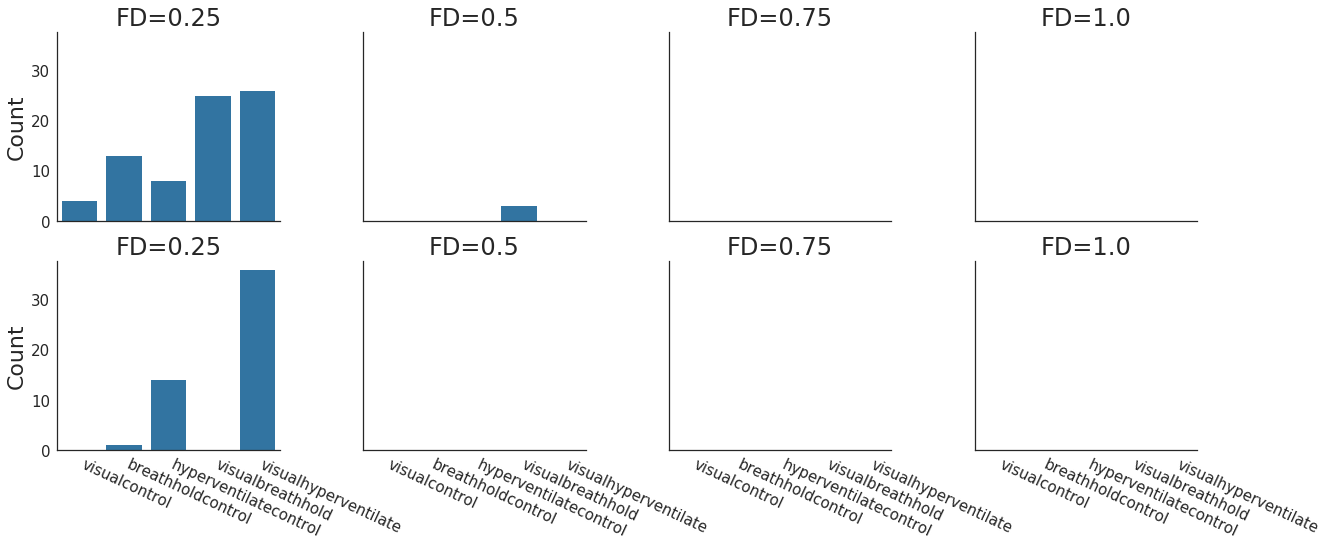

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define FD thresholds.
thresholds = [0.25, 0.50, 0.75, 1.00]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare confounds data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Iteratively load and prepare confounds reports.
confounds = []
for subj in subjects:
    
    for task in tasks:
        
        ## Define path.
        f = os.path.join(func_dir, subj, 'func', '%s_task-%s_bold_confounds.tsv' %(subj,task))
        
        ## Load data.
        df = read_csv(f, sep='\t')
        
        ## Insert metadata. Append.
        df.insert(0, 'Subject', subj)
        df.insert(1, 'Task', task)
        confounds.append(df)
        
## Concatenate reports.
confounds = concat(confounds)[df.columns]

## Identify volumes in excess of each FD threshold.
for fd in thresholds:
    
    confounds[fd] = confounds['FramewiseDisplacement'] > fd
    
## GroupBy subject/task.
gb = confounds.groupby(['Subject','Task'])[thresholds].sum().reset_index()
gb = gb.melt(id_vars=('Subject','Task'), var_name='Threshold', value_name='Count')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Seaborn FacetGrid.
g = sns.FacetGrid(gb, row='Subject', col='Threshold', size=3.5, aspect=1.25)
g.map(sns.barplot, 'Task', 'Count', order=tasks)

## Fix info.
g.set_xlabels('')
g.set_ylabels('Count', size=22)
g.set_xticklabels(rotation=-25, ha='left')
g.set_titles(template='FD={col_name}', size=24);

### Motion regressors
Finally, motion regressors are generated by detrending (remove mean / linear trend) and orthogonalizing the six motion timeseries. Only the first $N$ principal components that explain  $\geq$90% of the variance are included.

In [3]:
from scipy.signal import detrend
from sklearn.decomposition import PCA

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define FD threshold.
fd_threshold = 0.5

## Define variance explained threshold.
pca_threshold = 0.8

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Prepare save-directory.
out_dir = os.path.join('first_levels', 'regressors')
if not os.path.isdir(out_dir): os.makedirs(out_dir)

## Define z-score.
zscore = lambda arr: (arr - arr.mean()) / arr.std()
    
## Motion columns.
cols = ['X','Y','Z','RotX','RotY','RotZ']

for subj in subjects:

    for task in tasks:
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Prepare motion regressors.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
        ## Extract six degrees of movement.
        ix = np.logical_and(confounds.Subject==subj, confounds.Task==task)
        regressors = confounds.loc[ix, cols].values.copy()
        
        ## Detrend regressors.
        regressors = detrend(regressors, axis=0, type='linear')
        regressors = np.apply_along_axis(zscore, 0, regressors)

        ## Perform PCA.
        pca = PCA(n_components=6)
        regressors = pca.fit_transform(regressors)

        ## Take only the number of components explaining 90% of the variance.
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumulative_variance >= pca_threshold) + 1
        regressors = regressors[:,:n_components]
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Prepare motion scrubbers.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
        ## Include FD motion scrubbers (if applicable).
        scrubbers = confounds.loc[ix,fd_threshold].values.copy()
        if np.any(scrubbers): 
            indices, = np.where(scrubbers)
            scrubbers = np.zeros((regressors.shape[0], indices.size))
            scrubbers[(indices), (np.arange(indices.size))] = 1
            regressors = np.concatenate([regressors, scrubbers], axis=-1)
            
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Save motion regressors.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        ## Save.
        f = os.path.join(out_dir, '%s_task-%s_motion.txt' %(subj, task))
        np.savetxt(f, regressors)
        
print('Done.')

Done.


## Step 2: Highpass Filter

### Representative Example

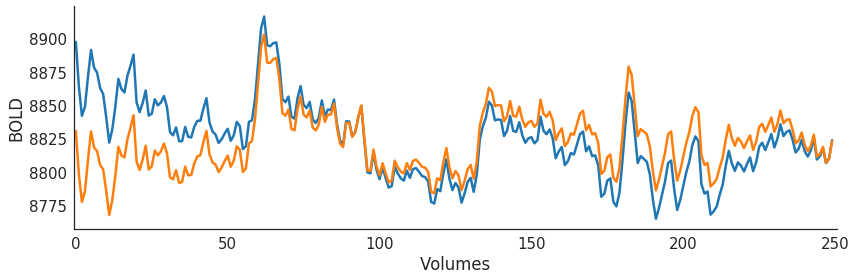

In [4]:
from nilearn.signal import clean

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Filter parameters.
high_pass = 1 / 120
t_r = 1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Filter data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data and visualize sample.
raw = read_gifti(sample)

## Compute mean signal.
mu = raw.mean(axis=0)

## Apply highpass data.
proc = clean(raw, detrend=True, standardize=False, high_pass=high_pass, t_r=t_r)
proc += mu    # Add back mean.

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
ax.plot(raw.mean(axis=-1), lw=2.5, label='Raw')
ax.plot(proc.mean(axis=-1), lw=2.5, label='Filtered')
ax.set(xlim=(-0.5, raw.shape[0]+0.5), xlabel='Volumes', ylabel='BOLD')

sns.despine()
plt.tight_layout()

### Filter and Normalize

In [5]:
from nilearn.signal import clean

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Filter parameters.
high_pass = 1 / 120
t_r = 1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Prepare save-directory.
out_dir = os.path.join('first_levels', 'psc')
if not os.path.isdir(out_dir): os.makedirs(out_dir)

for subj in subjects:
    
    for task in tasks:
                
        for space in spaces:
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Load and prepare data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            
            ## Load data.
            f = '%s_task-%s_bold_space-%s.func.gii' %(subj,task,space)
            f = os.path.join(func_dir, subj, 'func', f)
            data = read_gifti(f)
            
            ## Identify nonzero vertices.
            mask = np.abs(data).sum(axis=0).astype(bool)
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Filter and convert to PSC.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            
            ## Compute mean signal.
            mu = data[:,mask].mean(axis=0)

            ## Apply highpass data.
            data[:,mask] = clean(data[:,mask], detrend=True, standardize=False, 
                                 high_pass=high_pass, t_r=t_r)
            
            ## Convert to percent signal change.
            data[:,mask] = data[:,mask] / mu * 100
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Save.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            
            f = '%s_task-%s_space-%s.psc.npz' %(subj,task,space)
            f = os.path.join(out_dir, f)
            np.savez_compressed(f, psc=data, mask=mask)
            
print('Done.')

Done.
